In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer

In [107]:
train = pd.read_csv(Path('data','train.csv'))
# bronze = spark.table("prod.bronze.airbnb_listing")

In [108]:
train.shape

(34226, 16)

In [109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34226 entries, 0 to 34225
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              34226 non-null  int64  
 1   name                            34217 non-null  object 
 2   host_id                         34226 non-null  int64  
 3   host_name                       34212 non-null  object 
 4   neighbourhood_group             34226 non-null  object 
 5   neighbourhood                   34226 non-null  object 
 6   latitude                        34226 non-null  float64
 7   longitude                       34226 non-null  float64
 8   room_type                       34226 non-null  object 
 9   price                           34226 non-null  int64  
 10  minimum_nights                  34226 non-null  int64  
 11  number_of_reviews               34226 non-null  int64  
 12  last_review                     

In [110]:
train.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,9901706,Cute big one bedroom,1904415,Natalie,Manhattan,Upper West Side,40.77789,-73.97701,Entire home/apt,180,1,0,NaN,NaN,1,0
1,299531,Feel like you never leave your home,1220404,Tom,Brooklyn,East New York,40.66795,-73.89232,Entire home/apt,100,1,119,2019-06-30,1.39,2,289
2,2461439,Pristine Lower East Side Sanctuary,12586492,Sausan,Manhattan,Lower East Side,40.72007,-73.98946,Entire home/apt,133,14,177,2019-05-03,2.82,2,221
3,127387,"Luxe, Spacious 2BR 2BA Nr Trains",23276,Katharine,Brooklyn,Gowanus,40.66862,-73.99260,Entire home/apt,260,30,3,2014-08-04,0.03,1,316
4,629315,1BD brownstone apt in Fort Greene!,2397437,Lauren,Brooklyn,Fort Greene,40.68935,-73.96950,Entire home/apt,120,3,22,2015-10-28,0.27,1,189


In [111]:
train.groupby('name').size().sort_values(ascending=False)

name
Hillside Hotel                                        15
New york Multi-unit building                          11
Private room                                          10
Home away from home                                   10
Private Room                                           9
                                                      ..
Cozy front room in a 2 bedroom family apt near CU      1
Cozy flat with back Patio                              1
Cozy flat in Williamsburg                              1
Cozy farmhouse in NYC. 2 bdrms; 2 full baths. WiFi     1
ﾏﾝﾊｯﾀﾝ､駅から徒歩4分でどこに行くのにも便利な場所!女性の方希望,ｷﾚｲなお部屋｡           1
Length: 33704, dtype: int64

### Distribution of the target variable

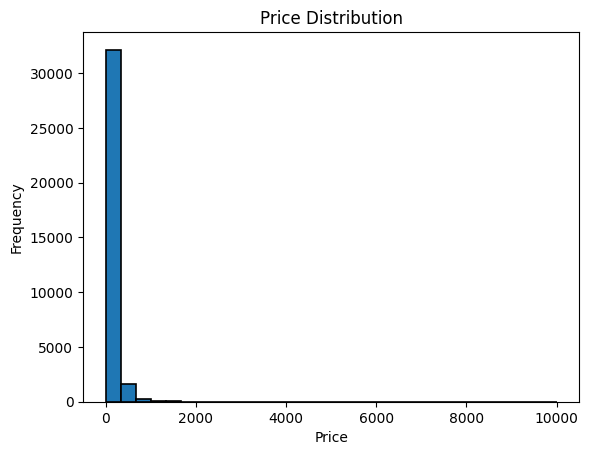

In [112]:
train['price'].plot(kind='hist',bins=30, edgecolor='black', linewidth=1.2)
plt.xlabel('Price')
plt.title('Price Distribution')
plt.show()

Price needs log transformation, price also has some zeros in it so need to +1 before we log transform
We can transform the price data right off the bat when I import data.

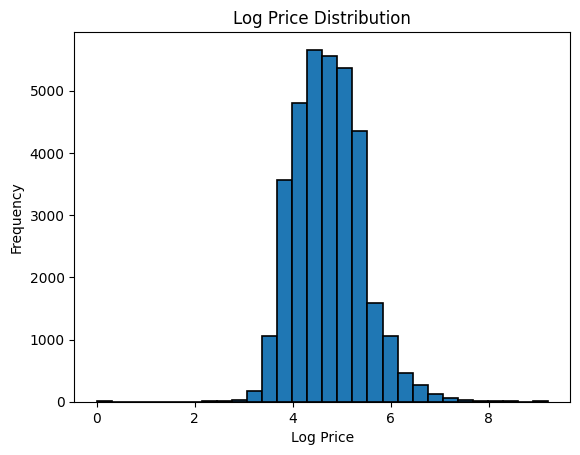

In [113]:
train['log_price'] = np.log(train['price']+1)
train['log_price'].plot(kind='hist',bins=30, edgecolor='black', linewidth=1.2)

# Title and xlabel
plt.xlabel('Log Price')
plt.title('Log Price Distribution')
plt.show()

In [120]:
# A function that computes the mean and median of unlogged price
def summarize_price(df):
    # average of the original (unlogged) price
    avg_price = np.exp(df['log_price'].mean())-1
    # median of the original (unlogged) price
    median_price = np.exp(df['log_price'].median())-1
    # number of listings
    n = len(df)
    
    res = pd.DataFrame({
        'average_price': [avg_price],
        'median_price': [median_price],
        'number_of_listings': [n]
    })
    return res.sort_values(by='number_of_listings', ascending=False)

In [121]:
summarize_price(train)

,average_price,median_price,number_of_listings
0,112.974459,105.0,34226


The average listing price is $112.97 per day.

### Let's group by neighbourbood, and look at themean and median price per day of each neighbourhood

In [123]:
res = train.groupby('neighbourhood_group')[['neighbourhood_group','log_price']]\
    .apply(summarize_price)\
    .sort_values(by='average_price', ascending=False)
    
res


,,average_price,median_price,number_of_listings
neighbourhood_group,,,,
Manhattan,0,148.557597,150.0,15146
Brooklyn,0,96.252210,90.0,14098
Staten Island,0,81.479831,75.0,249
Queens,0,78.430376,74.0,3972
Bronx,0,69.681428,65.0,761


Manhatten and Brooklyn have the largest average and median price, they also have large number of listings.

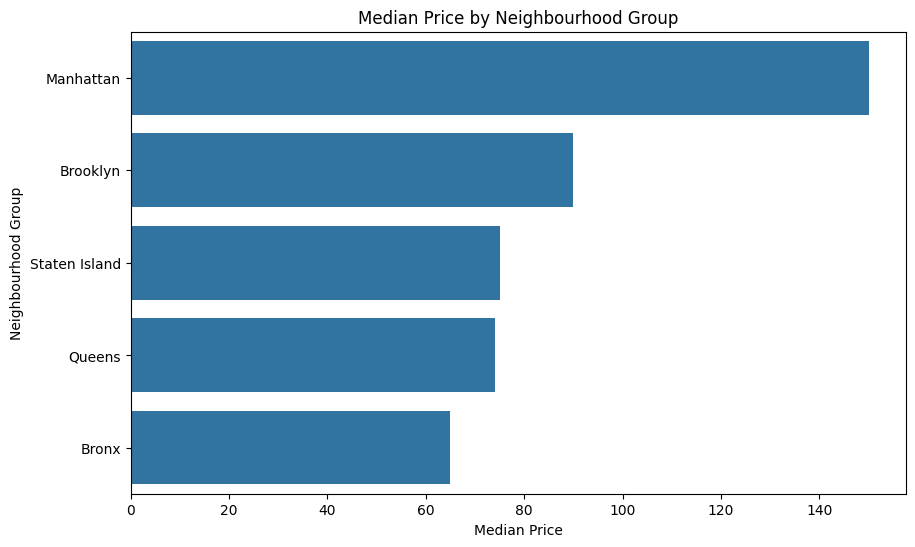

In [82]:
# Let's visualize this in a plot
plt.figure(figsize=(10, 6))
sns.barplot(x='median_price', y='neighbourhood_group', data=res)

# Add labels and title
plt.xlabel('Median Price')
plt.ylabel('Neighbourhood Group')
plt.title('Median Price by Neighbourhood Group')

# Show the plot
plt.show()

### Let's also see a boxplot of neighbourhood_group and price (unlogged)

Text(0.5, 1.0, 'Boxplot of Exponentiated Price by Neighbourhood Group')

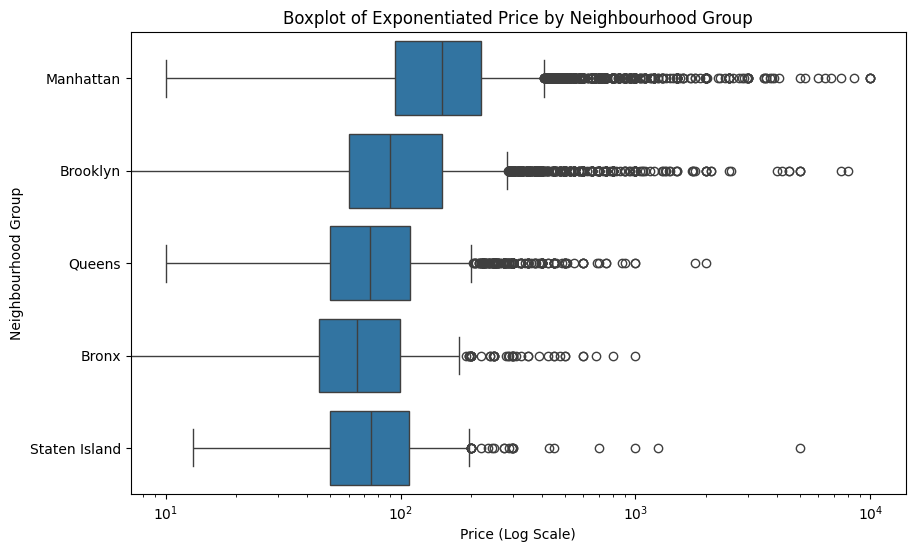

In [126]:
# The reason why I want to use the boxplot is because I can see if 
# there are variation (from the distribution) of the price in each group. 
# Since there is some variation, then we can include neighbourhood_group as a feature in my model.

# Create a boxplot with a log-transformed x-axis
plt.figure(figsize=(10, 6))
sns.boxplot(x='price', y='neighbourhood_group', data=train)

#Set the x-axis to log scale
plt.xscale('log')

# Add labels and title
plt.xlabel('Price (Log Scale)')
plt.ylabel('Neighbourhood Group')
plt.title('Boxplot of Exponentiated Price by Neighbourhood Group')

In [197]:
train['is_manhattan'] = train['neighbourhood_group'] == 'Manhattan'
train.is_manhattan.value_counts()

is_manhattan
False    19080
True     15146
Name: count, dtype: int64

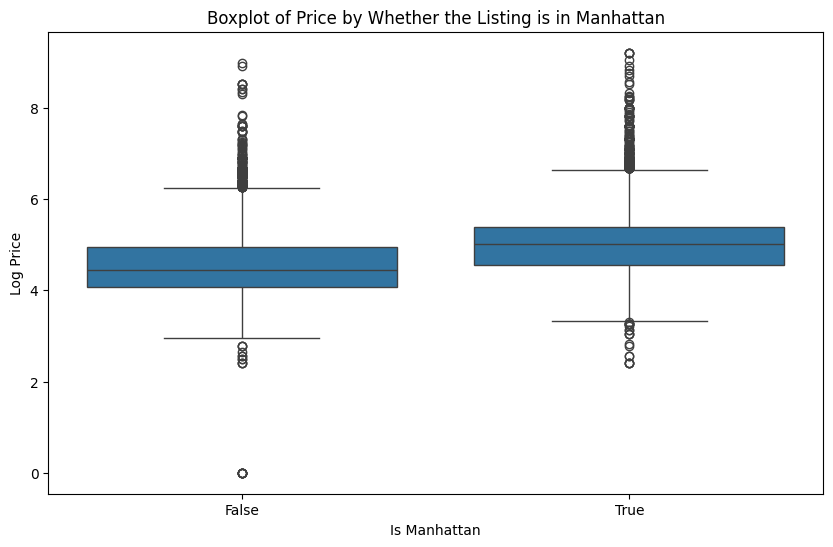

In [198]:
# Boxplot of price by whether the listing is in Manhattan
# Create Boxplot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(x='is_manhattan', y='log_price', data=df)

plt.title('Boxplot of Price by Whether the Listing is in Manhattan')
plt.xlabel('Is Manhattan')
plt.ylabel('Log Price')
plt.show()

We can use this binary feature instead of neighbourhood_group

### Association of neighbourhood (not neighbourhood_group) and price

In [127]:
train.neighbourhood.value_counts()

neighbourhood
Williamsburg          2720
Bedford-Stuyvesant    2597
Harlem                1831
Bushwick              1731
Upper West Side       1383
                      ... 
Woodrow                  1
Graniteville             1
Richmondtown             1
Spuyten Duyvil           1
New Dorp                 1
Name: count, Length: 217, dtype: int64

There are 217 neighbourhoods. I need to lump neighbourhoods for which there is only a few listings into a larger category. I will lump all neighbourhoods with less than 40 listings to a category called 'Other'. This will reduce the number of levels in the `neighbourhood` variable.

In [128]:
neighbourhood_counts = train['neighbourhood'].value_counts()
neighbourhood_counts

neighbourhood
Williamsburg          2720
Bedford-Stuyvesant    2597
Harlem                1831
Bushwick              1731
Upper West Side       1383
                      ... 
Woodrow                  1
Graniteville             1
Richmondtown             1
Spuyten Duyvil           1
New Dorp                 1
Name: count, Length: 217, dtype: int64

In [129]:
# The .map() function in pandas is used to map (or substitute) each value in a Series based on a mapping relationship, 
# such as a dictionary, a function, or a Series. It is particularly useful for element-wise transformations.
# Basically, for each row in train, I replace the neighbourhood value with the count of that neighbourhood in the train dataset.
train['neighbourhood'].map(neighbourhood_counts)

0        1383
1         142
2         616
3         180
4         343
         ... 
34221    1376
34222    2720
34223    1831
34224     319
34225    2597
Name: neighbourhood, Length: 34226, dtype: int64

In [132]:
# Use .where() to replace neighbourhoods with fewer than 40 samples with 'Other'
df = train.copy()
df['neighbourhood'] = df['neighbourhood'].where(df['neighbourhood'].map(neighbourhood_counts) >= 40, 'Other')
# Compute the mean listing of each neighbourhood
df['neghbourhood_mean'] = df.groupby('neighbourhood')['log_price'].transform('mean')
# sort the neighbourhoods by the mean price
df = df.sort_values(by='neghbourhood_mean', ascending=False)

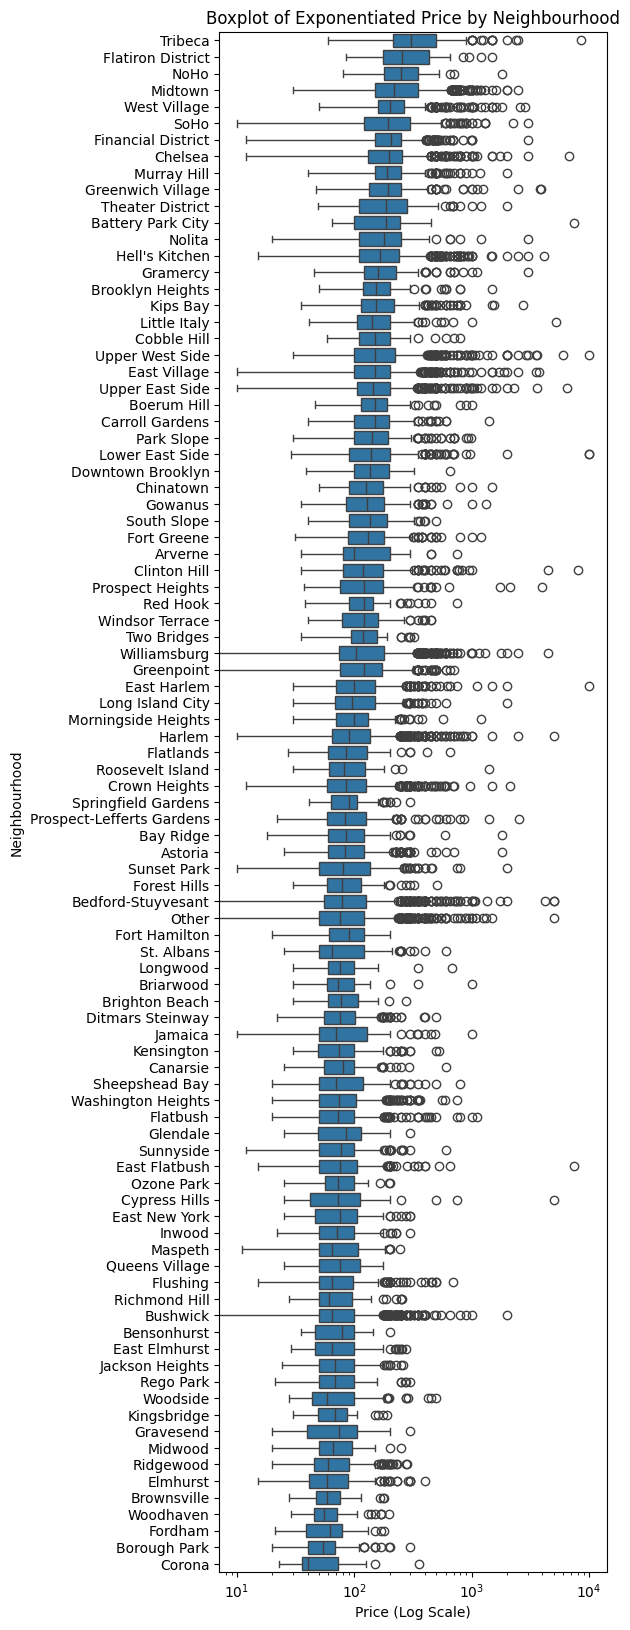

In [133]:
plt.figure(figsize=(5, 20))
sns.boxplot(x='price', y='neighbourhood', data=df)

# Add labels and title
plt.xlabel('Price (Log Scale)')
plt.ylabel('Neighbourhood')
plt.title('Boxplot of Exponentiated Price by Neighbourhood')

#Set the x-axis to log scale
plt.xscale('log')

# Show the plot
plt.show()

In [201]:
# Let's lump all rare neighbourhoods into 'Other' and then plot the boxplot again, as a percentage of sample
# Compute the percentage of listings in each neighbourhood

neighbourhood_percentage = train['neighbourhood'].value_counts(normalize=True) * 100
neighbourhood_percentage



neighbourhood
Williamsburg          7.947175
Bedford-Stuyvesant    7.587799
Harlem                5.349734
Bushwick              5.057559
Upper West Side       4.040788
                        ...   
Woodrow               0.002922
Graniteville          0.002922
Richmondtown          0.002922
Spuyten Duyvil        0.002922
New Dorp              0.002922
Name: proportion, Length: 217, dtype: float64

In [202]:
# Use .where() to replace neighborhoods with a percentage of listings below 2% with 'Other'
threshold_percentage = 1
df = train.copy()
df['neighbourhood'] = df['neighbourhood'].where(df['neighbourhood'].map(neighbourhood_percentage) >= threshold_percentage, 'Other')


In [205]:

# Compute the mean listing of each neighborhood
df['neighbourhood_mean'] = df.groupby('neighbourhood')['log_price'].transform('mean')

# Sort the neighborhoods by the mean price
df = df.sort_values(by='neighbourhood_mean', ascending=False)

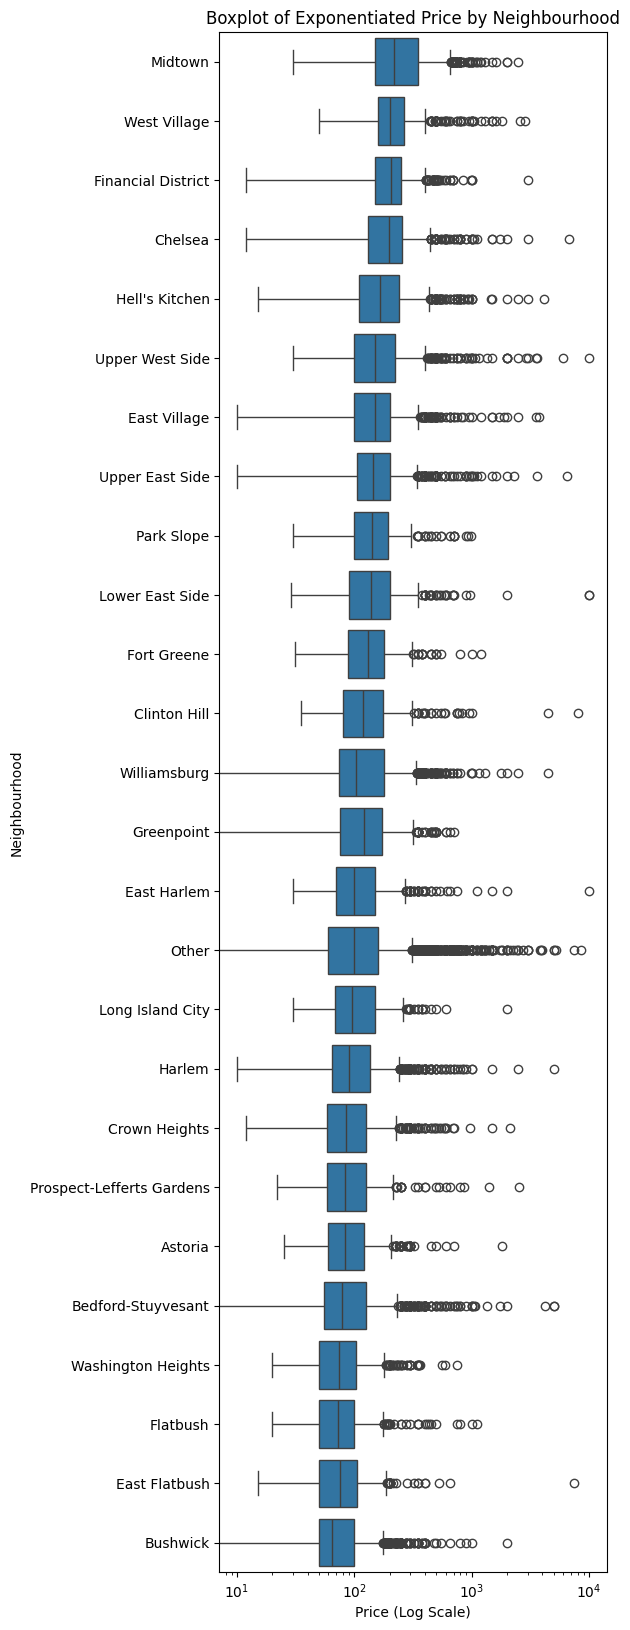

In [206]:
plt.figure(figsize=(5, 20))
sns.boxplot(x='price', y='neighbourhood', data=df)

# Add labels and title
plt.xlabel('Price (Log Scale)')
plt.ylabel('Neighbourhood')
plt.title('Boxplot of Exponentiated Price by Neighbourhood')

#Set the x-axis to log scale
plt.xscale('log')

# Show the plot
plt.show()

### Association between room_type and price
- Entire home and more expensive on average than private room, which in turn is more expensive than shared room.

In [134]:
# Use .where() to replace neighbourhoods with fewer than 40 samples with 'Other'
df = train.copy()
# Compute the mean listing of each neighbourhood
df['room_type_mean'] = df.groupby('room_type')['log_price'].transform('mean')
# sort the neighbourhoods by the mean price
df = df.sort_values(by='room_type_mean', ascending=False)

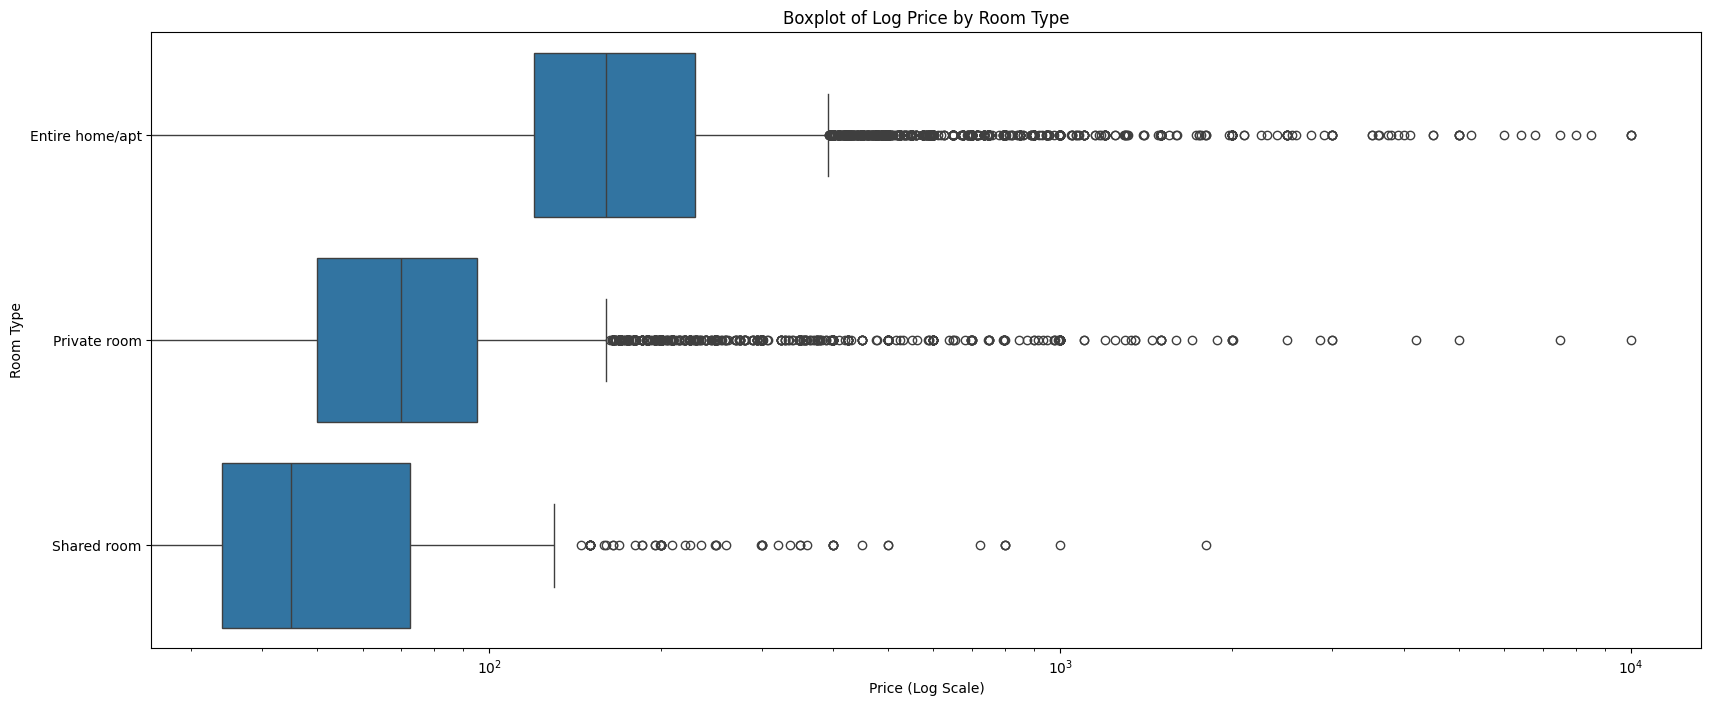

In [135]:
plt.figure(figsize=(20, 8))
sns.boxplot(x='price', y='room_type', data=df)

# Add labels and title
plt.xlabel('Price (Log Scale)')
plt.ylabel('Room Type')
plt.title('Boxplot of Log Price by Room Type')

#Set the x-axis to log scale
plt.xscale('log')

# Show the plot
plt.show()

### Minimum Nights and price
- No clear trends

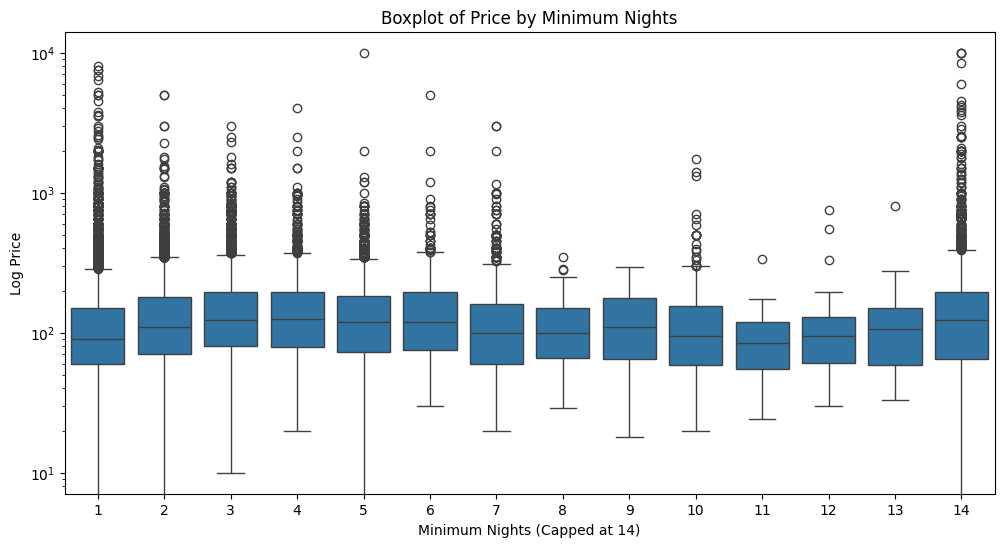

In [143]:
# Minimum nights is a numeric variable. I want to split it into groups, and then set
# an upper bound (limit it to at most 14 nights). If anything is over 14 nights, I will cap
# it at 14 nights. 
df = train.copy()
train['minimum_nights'] = np.minimum(train['minimum_nights'], 14)
train.minimum_nights.value_counts()

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='minimum_nights', y='price', data=train)
plt.yscale('log')

# Add labels and title
plt.xlabel('Minimum Nights (Capped at 14)')
plt.ylabel('Log Price')
plt.title('Boxplot of Price by Minimum Nights')

# Show the plot
plt.show()

### Number of reviews and price

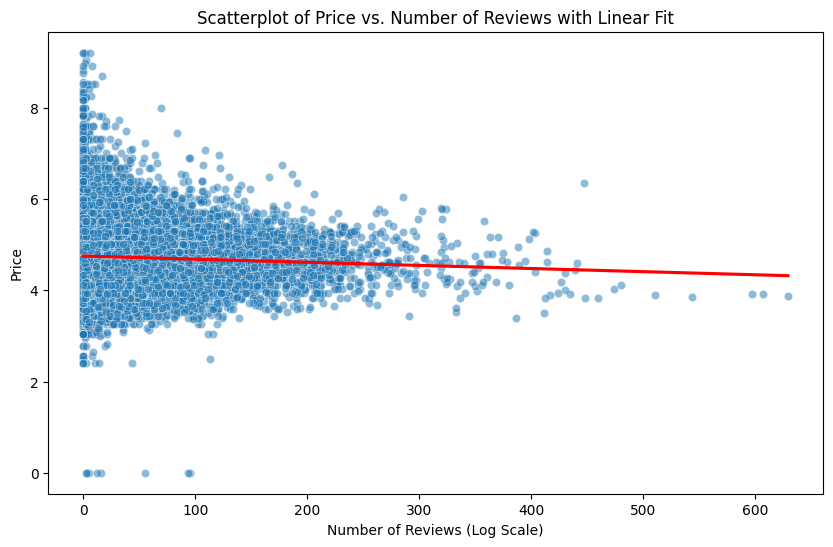

In [154]:
# Create the scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='number_of_reviews', y='log_price', data=train, alpha=0.5)

# Add a linear regression trend line
sns.regplot(x='number_of_reviews', y='log_price', data=train, scatter=False, ci=None, line_kws={'color': 'red'})

# Add labels and title
plt.xlabel('Number of Reviews (Log Scale)')
plt.ylabel('Price')
plt.title('Scatterplot of Price vs. Number of Reviews with Linear Fit')

# Show the plot
plt.show()

### Association betwen calculated_host_listing_count and price

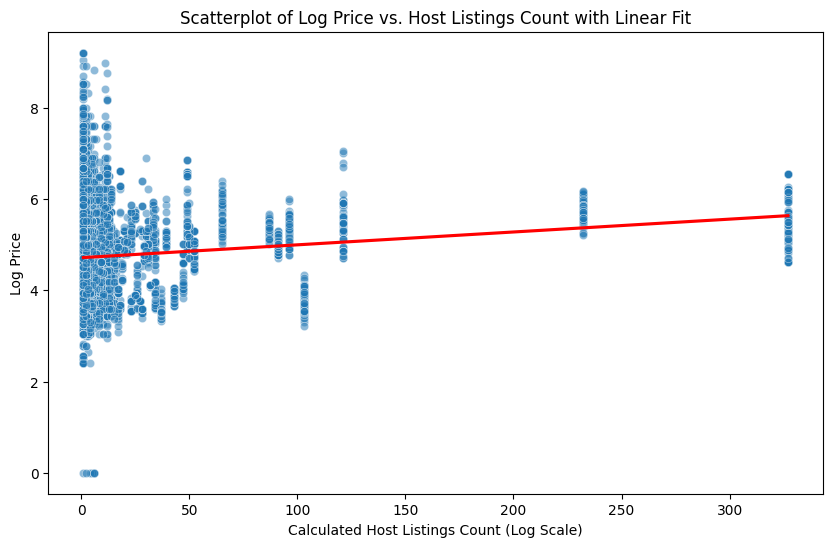

In [153]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='calculated_host_listings_count', y='log_price', data=train, alpha=0.5)

# Add a linear regression trend line
sns.regplot(x='calculated_host_listings_count', y='log_price', data=train, 
            scatter=False, ci=None, line_kws={'color': 'red'})

# Add labels and title
plt.xlabel('Calculated Host Listings Count (Log Scale)')
plt.ylabel('Log Price')
plt.title('Scatterplot of Log Price vs. Host Listings Count with Linear Fit')

# Show the plot
plt.show()

Weak association for both number of reviews and calculated host listings count with price.

### Latitude and Longitude and price

In [158]:
# Round latitude and longitude to reduce the number of points
train['latitude_rounded'] = train['latitude'].round(2)
train['longitude_rounded'] = train['longitude'].round(2)

# Aggregate price by averaging within each lat-lon group
train_grouped = train.groupby(['latitude_rounded', 'longitude_rounded'])['price'].mean().reset_index()

train_grouped

,latitude_rounded,longitude_rounded,price
0,40.51,-74.24,199.5
1,40.51,-74.23,75.0
2,40.52,-74.21,85.0
3,40.52,-74.18,185.0
4,40.53,-74.20,1250.0
...,...,...,...
684,40.90,-73.85,113.2
685,40.90,-73.84,67.5
686,40.91,-73.91,50.0
687,40.91,-73.90,53.0


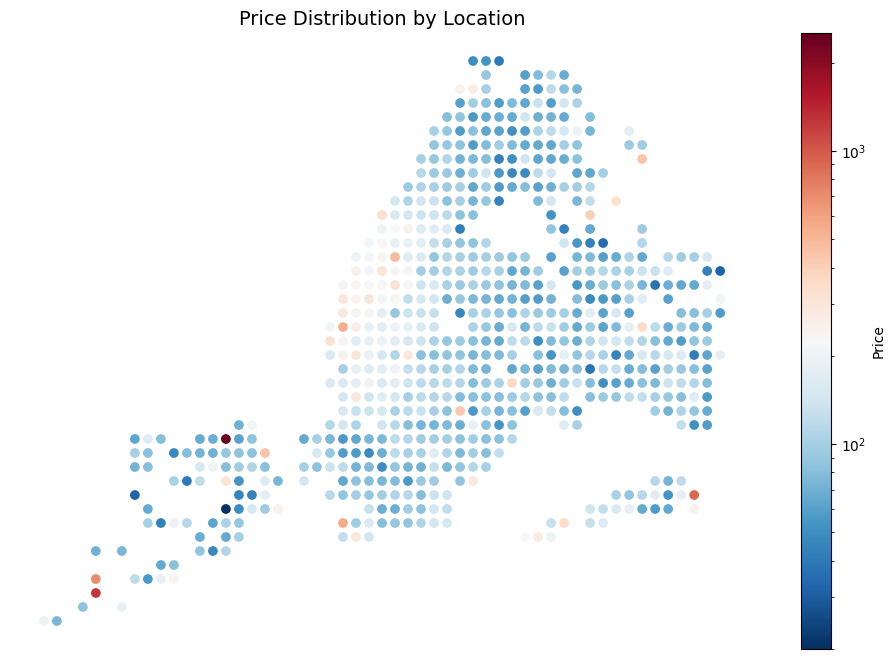

In [159]:

plt.figure(figsize=(12, 8))
sc = plt.scatter(train_grouped['longitude_rounded'], train_grouped['latitude_rounded'], 
                 c=train_grouped['price'], cmap='RdBu_r', norm=plt.matplotlib.colors.LogNorm())

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Price")

# Remove axis for a map-like theme
plt.axis('off')

# Add title
plt.title("Price Distribution by Location", fontsize=14)

# Show the plot
plt.show()

Some areas in NYC has more expensive listing than others.

### Last review date and price

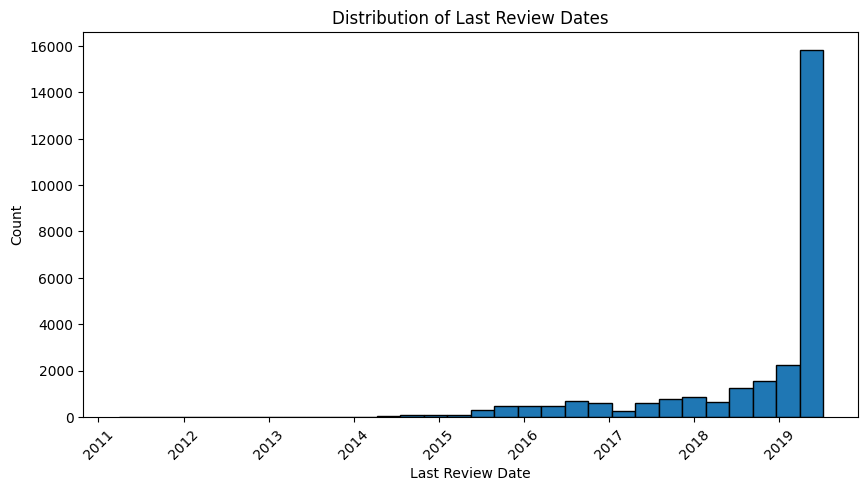

In [160]:
# Convert 'last_review' to datetime if not already
train['last_review'] = pd.to_datetime(train['last_review'], errors='coerce')

# Create the histogram
plt.figure(figsize=(10, 5))
plt.hist(train['last_review'].dropna(), bins=30, edgecolor='black')

# Add labels and title
plt.xlabel("Last Review Date")
plt.ylabel("Count")
plt.title("Distribution of Last Review Dates")
plt.xticks(rotation=45)
plt.show()

- Most of the last_review are in 2019. 
- Maybe we can derive a new feature called days since last review.

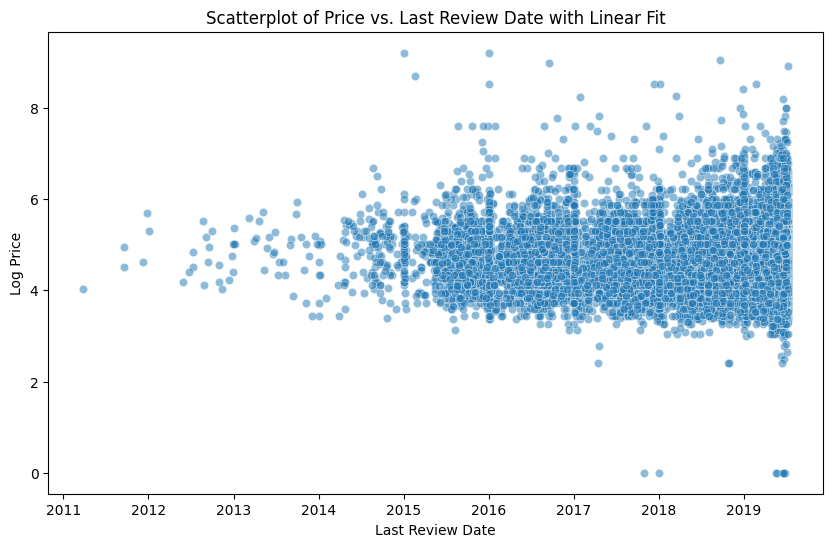

In [163]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='last_review', y='log_price', data=train, alpha=0.5)

# Format x-axis labels
plt.xlabel("Last Review Date")
plt.ylabel("Log Price")
plt.title("Scatterplot of Price vs. Last Review Date with Linear Fit")

# Show the plot
plt.show()

No clear trend if we use last review data. We probably need to engineer some more useful features here.

### I will derive a new feature that take the difference between today and last_review (so I have elapsed time of last review).

In [167]:
# Get the current date
current_date = datetime.now()

# Compute the number of days elapsed since last_review
train['elapsed_days'] = (current_date - train['last_review']).dt.days

### Use tf-idf to featurize the 'name' column

In [171]:
train.name

0                                     Cute big one bedroom
1                      Feel like you never leave your home
2                       Pristine Lower East Side Sanctuary
3                         Luxe, Spacious 2BR 2BA Nr Trains
4                       1BD brownstone apt in Fort Greene!
                               ...                        
34221                                     Clean and Simple
34222                       Best location in Williamsburg!
34223      Hamilton Studio. 2Queen. priv bath. kitchenette
34224                      Best CoLiving next to Bushwick!
34225    Birdman movie Room in Brooklyn.30 Min to Manha...
Name: name, Length: 34226, dtype: object

In [185]:
# Fill NA with an empty string
train['name'] = train['name'].fillna('')
# Set a limit for the number of features
tfidf = TfidfVectorizer(stop_words='english', max_features=100)
sparse_text_mat = tfidf.fit_transform(train['name'])

In [186]:
tfidf_features = tfidf.get_feature_names_out()
tfidf_features

array(['1br', '2br', 'amazing', 'apartment', 'apt', 'artist', 'astoria',
       'away', 'backyard', 'balcony', 'bath', 'bathroom', 'beautiful',
       'bed', 'bedroom', 'best', 'big', 'br', 'bright', 'brooklyn',
       'brownstone', 'building', 'bushwick', 'central', 'charming',
       'chelsea', 'city', 'clean', 'close', 'comfortable', 'comfy',
       'cozy', 'cute', 'doorman', 'duplex', 'east', 'entire', 'floor',
       'furnished', 'garden', 'gorgeous', 'great', 'greenpoint', 'gym',
       'harlem', 'heart', 'heights', 'hill', 'home', 'house', 'huge',
       'jfk', 'kitchen', 'large', 'location', 'loft', 'lovely', 'luxury',
       'manhattan', 'midtown', 'min', 'mins', 'minutes', 'modern', 'near',
       'new', 'ny', 'nyc', 'oasis', 'park', 'perfect', 'place', 'prime',
       'private', 'prospect', 'queen', 'quiet', 'renovated', 'room',
       'shared', 'slope', 'soho', 'space', 'spacious', 'square', 'studio',
       'subway', 'suite', 'sunny', 'times', 'townhouse', 'train', 'upper'

In [184]:
name_df = pd.DataFrame(sparse_text_mat.toarray(), columns=tfidf_features)
name_df

,10,10min,116,12,15,15min,1bd,1br,1st,20,...,williamsburg,window,windows,wonderful,wyndham,xl,yankee,yard,york,zen
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.508381,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34221,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34222,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.487454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34223,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34224,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create Manhatten binary variable

In [191]:
df['is_manhattan'] = df['neighbourhood_group'] == 'Manhattan'
df.is_manhatten.value_counts()

is_manhatten
False    19080
True     15146
Name: count, dtype: int64

### Possible feature engineering steps
- log price
- apply tf-idf to name
- binarize neighbourhood_group to "is_manhattan"
- Cap minimum nights at 14
- Compute elapsed days since last review
- Replace neighbourhoods with fewer X percentage with 'Other'